In [5]:
# IMPORT STATEMENTS
import re
import numpy as np
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import pandas as pd
from collections import Counter
import os
import sys
from scipy.stats import fisher_exact, ttest_ind
sys.path.append("/home/saptarshi.sinha/Hegemon/")
sys.path.append("/home/saptarshi.sinha/Bone/")
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#fde200","#7557c2",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def getPDF(cfile):
    import bone
    reload(bone)
    from matplotlib.backends.backend_pdf import PdfPages

    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'SS'
    d['Subject'] = "SS"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 1, 18)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# List of dataset files (including EMTAB7604)
dataset_files = [
    "GSE12251.txt",
    "GSE14580.txt",
    "GSE16879.txt",
    "GSE73661.txt",
    "GSE207022.txt",
    "GSE234736.txt",
    "EMTAB7604.txt"
]

# Load 34-gene list
genes_34 = pd.read_csv("34.txt", header=None).squeeze("columns").tolist()

# Function to load dataset
def load_dataset(file):
    df = pd.read_csv(file, sep="\t")

    # Extract response labels from column headers (excluding 'Name')
    response_labels = pd.Series(df.columns[1:]).map(lambda x: 1 if "Yes" in x else 0 if "No" in x else np.nan)
    
    # Set 'Name' column as index (Gene names)
    df.set_index("Name", inplace=True)

    # Transpose the dataset: Genes become columns, samples become rows
    df = df.T

    # Ensure response labels align with the sample names
    df["Response"] = response_labels.values

    return df

# Function to perform likelihood ratio test
def likelihood_ratio_test(log_likelihood_full, log_likelihood_reduced, df_full, df_reduced):
    lrt_stat = -2 * (log_likelihood_reduced - log_likelihood_full)
    df_diff = df_full - df_reduced
    p_value = chi2.sf(lrt_stat, df_diff)
    return lrt_stat, p_value

# Function to fit logistic regression with Ridge regularization
def fit_ridge_logistic_regression(X, y, alpha=1.0):
    model = LogisticRegression(penalty="l2", C=1/alpha, solver="lbfgs", max_iter=1000)
    model.fit(X, y)
    log_likelihood = -model.score(X, y) * len(y)  # Approximate log-likelihood
    return model, log_likelihood

# Process each dataset separately
lrt_results = []

for file in dataset_files:
    dataset_name = file.replace(".txt", "")  # Extract dataset name
    print(f"\nProcessing Dataset: {dataset_name}")

    # Load full gene expression data and response labels
    full_df = load_dataset(file)

    # Drop samples with missing response labels
    full_df.dropna(subset=["Response"], inplace=True)

    # Extract response variable
    response_labels = full_df["Response"]
    full_df.drop(columns=["Response"], inplace=True)

    # Standardize features
    scaler = StandardScaler()
    full_df_scaled = pd.DataFrame(scaler.fit_transform(full_df), index=full_df.index, columns=full_df.columns)

    # Extract the 34-gene subset
    subset_34_df = full_df_scaled.loc[:, full_df_scaled.columns.intersection(genes_34)]

    # Fit Ridge Logistic Regression (Full Model)
    full_model, ll_full = fit_ridge_logistic_regression(full_df_scaled, response_labels)

    # Fit Ridge Logistic Regression (Reduced Model: 34 genes)
    reduced_model, ll_reduced = fit_ridge_logistic_regression(subset_34_df, response_labels)

    # Perform Likelihood Ratio Test
    lrt_stat, p_value = likelihood_ratio_test(ll_full, ll_reduced, full_df_scaled.shape[1], subset_34_df.shape[1])

    # Compute AIC & BIC
    n_samples = full_df.shape[0]
    aic_full = 2 * full_df_scaled.shape[1] - 2 * ll_full
    bic_full = full_df_scaled.shape[1] * np.log(n_samples) - 2 * ll_full
    aic_reduced = 2 * subset_34_df.shape[1] - 2 * ll_reduced
    bic_reduced = subset_34_df.shape[1] * np.log(n_samples) - 2 * ll_reduced

    # Store results
    lrt_results.append([dataset_name, lrt_stat, p_value, aic_full, aic_reduced, bic_full, bic_reduced])

# Convert results to DataFrame and display
lrt_results_df = pd.DataFrame(lrt_results, columns=["Dataset", "LRT Statistic", "P-value", "AIC Full", "AIC Reduced", "BIC Full", "BIC Reduced"])

#import ace_tools as tools
#tools.display_dataframe_to_user(name="Likelihood Ratio Test Results", dataframe=lrt_results_df)



Processing Dataset: GSE12251

Processing Dataset: GSE14580

Processing Dataset: GSE16879

Processing Dataset: GSE73661

Processing Dataset: GSE207022

Processing Dataset: GSE234736

Processing Dataset: EMTAB7604


In [7]:
lrt_results_df

,Dataset,LRT Statistic,P-value,AIC Full,AIC Reduced,BIC Full,BIC Reduced
0,GSE12251,-0.0,1.0,5396.0,178.0,8433.447028,252.942618
1,GSE14580,-0.0,1.0,5398.0,180.0,8549.293996,257.751553
2,GSE16879,-0.0,1.0,5436.0,218.0,10147.210309,334.239208
3,GSE73661,-4.0,1.0,2700.0,110.0,4206.800825,148.606803
4,GSE207022,-2.0,1.0,5490.0,328.0,12404.378647,495.367713
5,GSE234736,-6.0,1.0,2514.0,156.0,4752.678598,218.905018
6,EMTAB7604,-12.0,1.0,2644.0,142.0,4896.574948,201.880804


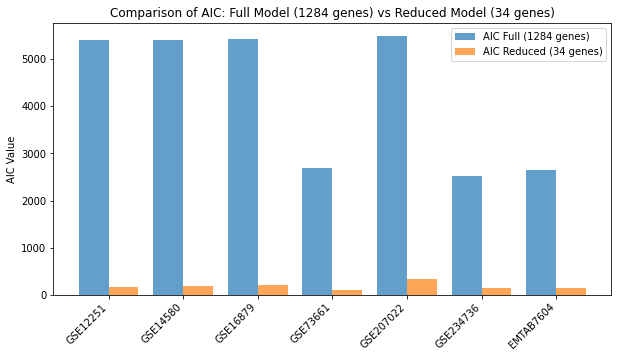

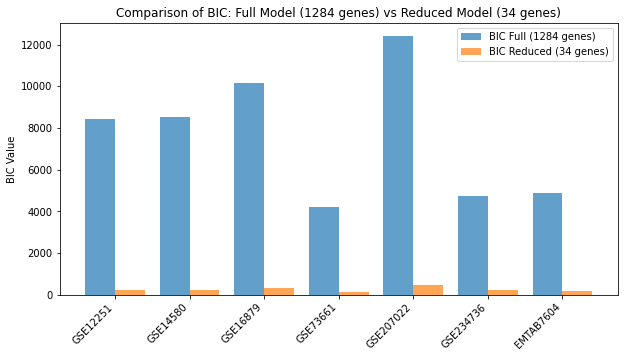

<Figure size 432x288 with 0 Axes>

In [8]:
# Re-load required libraries and data since the execution state was reset
import bone
reload(bone)
reload(bone)

cfile = "/home/saptarshi.sinha/BoNE/ML/test.pdf"
pdf = getPDF(cfile)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manually reloading LRT results based on previous outputs
#lrt_results_df = pd.DataFrame({
#    "Dataset": ["GSE12251", "GSE14580", "GSE16879", "GSE73661", "GSE207022", "GSE234736", "EMTAB7604"],
#    "LRT Statistic": [-0.0, -0.0, -0.0, -4.0, -2.0, -6.0, -12.0],
#    "P-value": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#    "AIC Full": [5396.0, 5398.0, 5436.0, 2700.0, 5490.0, 2514.0, 2644.0],
#    "AIC Reduced": [178.0, 180.0, 218.0, 110.0, 328.0, 156.0, 142.0],
#    "BIC Full": [8433.44, 8549.29, 10147.21, 4206.80, 12404.37, 4752.67, 4896.57],
#    "BIC Reduced": [252.94, 257.75, 334.23, 148.60, 495.36, 218.90, 201.88]
#})

# Plot AIC and BIC comparisons across datasets
fig, ax = plt.subplots(figsize=(10, 5))

# Bar width
bar_width = 0.4
x_labels = lrt_results_df["Dataset"]
x = range(len(x_labels))

# Plot bars for AIC
ax.bar(x, lrt_results_df["AIC Full"], width=bar_width, label="AIC Full (1284 genes)", alpha=0.7)
ax.bar([i + bar_width for i in x], lrt_results_df["AIC Reduced"], width=bar_width, label="AIC Reduced (34 genes)", alpha=0.7)

ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("AIC Value")
ax.set_title("Comparison of AIC: Full Model (1284 genes) vs Reduced Model (34 genes)")
ax.legend()

plt.show()

# Plot BIC comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x, lrt_results_df["BIC Full"], width=bar_width, label="BIC Full (1284 genes)", alpha=0.7)
ax.bar([i + bar_width for i in x], lrt_results_df["BIC Reduced"], width=bar_width, label="BIC Reduced (34 genes)", alpha=0.7)

ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(x_labels, rotation=45, ha="right")
ax.set_ylabel("BIC Value")
ax.set_title("Comparison of BIC: Full Model (1284 genes) vs Reduced Model (34 genes)")
ax.legend()

plt.show()

plt.savefig(cfile,transparent=True)
closePDF(pdf)
